### Аппроксимация ценового ряда на золото рядами Фурье и методом градиентного спуска

## Подготовительный этап

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timeit

df = pd.read_csv('../Gold-GCc1-COMEX-USD-monthly.csv')
df['date'] = pd.to_datetime(df['date'])
df['days'] = (df['date'] - df['date'].min()).dt.days

df.head()

,date,price,currency,Gold Futures (GCc1),1178340,https://www.investing.com/commodities/gold-historical-data?cid=1178340,USD,1 Troy Ounce,1.0,days
0,1978-02-01,212.800003,1.0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1978-03-01,212.000000,1.0,NaN,NaN,NaN,NaN,NaN,NaN,28
2,1978-04-01,192.300003,1.0,NaN,NaN,NaN,NaN,NaN,NaN,59
3,1978-05-01,211.199997,1.0,NaN,NaN,NaN,NaN,NaN,NaN,89
4,1978-06-01,207.800003,1.0,NaN,NaN,NaN,NaN,NaN,NaN,120


In [3]:
t = df['days'].values
y = df['price'].values

print(df['price'].describe())

count     558.000000
mean      764.810842
std       553.623555
min       192.300003
25%       354.350006
50%       425.350006
75%      1238.624969
max      2426.500000
Name: price, dtype: float64


Нормализуем временной ряд

In [4]:
y = abs(y - y.mean()) / y.std()
T = t.max() - t.min()

Функцию ошибки (SSE)

In [5]:
def loss_sse(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

Модель ряда Фурье

In [6]:
def fourier_series(t_train, N, A, phi, T):
    result = A[0]  # Константная компонента
    for n in range(1, N + 1):   
        result += A[n] * np.cos(2 * np.pi * n * t_train / T + phi[n-1])
    return result

## Функция `fit_fourier_gd`


Функция подбирает параметры ряда Фурье для аппроксимации временного ряда методом классического градиентного спуска.

**Входные параметры:**
- `t_train`: Массив временных точек
- `y_train`: Массив значений временного ряда
- `N`: Количество гармоник в ряде Фурье
- `T`: Период
- `tol`: Константное значение, относительного которого будет проверяться изменение ошибки
- `max_iter`: Константное значение, задающиее максимальное количество итераций, для случая, если градиентный спуск не остановится за определенное количество итераций по критериям остановки

**Выходные значения:**
- `A`: Массив амплитуд гармоник
- `phi`: Массив фаз гармонк

In [9]:
def fit_fourier_gd(t_train, y_train, N, T, tol=1e-3, max_iter = 5000):
    A = np.random.randn(N + 1) * 0.1  # A[0] + N гармоник
    A[0] = y_train.mean()  # Инициализация постоянной составляющей средним значением
    phi = np.random.uniform(-np.pi, np.pi, N)

    alpha = 0.001  # Скорость обучения
    prev_loss = np.inf  
    current_loss = np.inf

    for i in range(max_iter):

        y_pred = fourier_series(t_train, N, A, phi, T) 
        current_loss = loss_sse(y_train, y_pred)

        # Вычисление градиентов для амплитуд
        dA = np.zeros_like(A)
        dA[0] = -2 * np.sum(y_train - y_pred)
        for n in range(1, N + 1):
            dA[n] = -2 * np.sum((y_train - y_pred) * np.cos(2 * np.pi * n * t_train / T + phi[n-1]))
        
        # Вычисление градиентов для фаз
        dphi = np.zeros_like(phi)
        for n in range(1, N + 1):
            dphi[n-1] = 2 * np.sum((y_train - y_pred) * A[n] * np.sin(2 * np.pi * n * t_train / T + phi[n-1]))

        # Сохраняем старые параметры для проверки сходимости
        old_A = A.copy()
        old_phi = phi.copy()

        # Обновление параметров
        A -= alpha * dA
        phi -= alpha * dphi
        
        # Регуляризация параметров
        A = np.clip(A, -10, 10)
        phi = np.clip(phi, -np.pi, np.pi)

        # if i % 100 == 0:
        #     print(f"Итерация {i}, ошибка: {current_loss:.4f}")

        # Проверка сходимости (изменение параметров)
        param_change = np.linalg.norm(A - old_A) + np.linalg.norm(phi - old_phi)
        if param_change < tol:
            #print(f"Ранняя остановка на итерации {i}, изменение параметров: {param_change:.2e}")
            break

        # Проверка сходимости (изменение ошибки)
        if abs(prev_loss - current_loss) < tol:
            #print(f"Ранняя остановка на итерации {i}, изменение ошибки: {abs(prev_loss - current_loss):.2e}")
            break  

        prev_loss = current_loss          

    current_loss = 0        
    return A, phi

## Функция `fit_fourier_adam`


Функция подбирает параметры ряда Фурье для аппроксимации временного ряда методом Adam.

**Входные параметры:**
- `t_train`: Массив временных точек
- `y_train`: Массив значений временного ряда
- `N`: Количество гармоник в ряде Фурье
- `T`: Период
- `tol`: Константное значение, относительного которого будет проверяться изменение ошибки
- `max_iter`: Константное значение, задающиее максимальное количество итераций, для случая, если градиентный спуск не остановится за определенное количество итераций по критериям остановки

**Выходные значения:**
- `A`: Массив амплитуд гармоник
- `phi`: Массив фаз гармонк

In [8]:
# Adam
def fit_fourier_adam(t_train, y_train, N, T, tol=1e-3, max_iter = 5000):
    A = np.random.randn(N + 1) * 0.1  # A[0] + N гармоник
    A[0] = y_train.mean()  # Инициализация постоянной составляющей средним значением
    phi = np.random.uniform(-np.pi, np.pi, N)
    
    prev_loss = np.inf  
    current_loss = np.inf

    # Параметры для метода Adam
    alpha = 0.001  # Начальная скорость обучения
    beta1 = 0.9   # Параметр для скользящего среднего градиента
    beta2 = 0.999 # Параметр для скользящего среднего квадрата градиента
    epsilon = 1e-8 # Малое число для предотвращения деления на 0

    # Инициализация моментов
    mA = np.zeros_like(A)
    vA = np.zeros_like(A)
    mphi = np.zeros_like(phi)
    vphi = np.zeros_like(phi)

    for i in range(max_iter):

        y_pred = fourier_series(t_train, N, A, phi, T)
        current_loss = loss_sse(y_train, y_pred)

        # Градиенты по амплитудам A0, A1,...AN
        dA = np.zeros_like(A)
        dA[0] = -2 * np.sum(y_train - y_pred)
        for n in range(1, N + 1):
            dA[n] = -2 * np.sum((y_train - y_pred) * np.cos(2 * np.pi * n * t_train / T + phi[n-1]))

        # Градиенты по фазам phi1,...phiN
        dphi = np.zeros_like(phi)
        for n in range(1, N + 1):
            dphi[n-1] = 2 * np.sum((y_train - y_pred) * A[n] * np.sin(2 * np.pi * n * t_train / T + phi[n-1]))

        # Обновление моментов для A
        mA = beta1 * mA + (1 - beta1) * dA
        vA = beta2 * vA + (1 - beta2) * (dA ** 2)

        # Обновление моментов для phi
        mphi = beta1 * mphi + (1 - beta1) * dphi
        vphi = beta2 * vphi + (1 - beta2) * (dphi ** 2)

        # Коррекция смещения моментов
        mA_hat = mA / (1 - beta1 ** (i + 1))
        vA_hat = vA / (1 - beta2 ** (i + 1))
        mphi_hat = mphi / (1 - beta1 ** (i + 1))
        vphi_hat = vphi / (1 - beta2 ** (i + 1))

        # Сохраняем старые параметры для проверки сходимости
        old_A = A.copy()
        old_phi = phi.copy()

        # Обновление параметров
        A -= alpha * mA_hat / (np.sqrt(vA_hat) + epsilon)
        phi -= alpha * mphi_hat / (np.sqrt(vphi_hat) + epsilon)

        # Добавляем регуляризацию
        A = np.clip(A, -10, 10)
        phi = np.clip(phi, -np.pi, np.pi)

        # В критериях остановки закомментируем принты, чтобы они не мешали при проверки скорости

        # if i % 100 == 0:
        #     print(f"Итерация {i}, ошибка: {current_loss:.4f}")

        # Проверка сходимости (изменение параметров)
        param_change = np.linalg.norm(A - old_A) + np.linalg.norm(phi - old_phi)
        if param_change < tol:
            #print(f"Ранняя остановка на итерации {i}, изменение параметров: {param_change:.2e}")
            break

        # Проверка сходимости (изменение ошибки)
        if abs(prev_loss - current_loss) < tol:
            #print(f"Ранняя остановка на итерации {i}, изменение ошибки: {abs(prev_loss - current_loss):.2e}")
            break  

    return A, phi


## Сравнение двух методов оптимизации для решения нашей задачи

In [10]:
# Создаем таблицу для хранения результатов (2 строки - GD и Adam, 10 столбцов - запусков)
results_table = np.zeros((2, 10))

for i in range(10):

    N = 10
    # Замеряем время выполнения
    time_func1 = timeit.timeit("fit_fourier_gd(t, y, N, T)", globals=globals(), number=1)
    time_func2 = timeit.timeit("fit_fourier_adam(t, y, N, T)", globals=globals(), number=1)

    # Записываем результаты в таблицу
    results_table[0, i] = time_func1  # GD
    results_table[1, i] = time_func2  # Adam

# Выводим таблицу результатов
print("Таблица времени выполнения (секунды):")
print("GD   :", " ".join(f"{t:.5f}" for t in results_table[0]))
print("Adam :", " ".join(f"{t:.5f}" for t in results_table[1]))

# Сравниваем среднее время
mean_gd = np.mean(results_table[0])
mean_adam = np.mean(results_table[1])

print(f"\nСреднее время GD: {mean_gd:.5f} сек")
print(f"Среднее время Adam: {mean_adam:.5f} сек")

if mean_gd < mean_adam:
    print("GD быстрее в среднем!")
else:
    print("Adam быстрее в среднем!")

Таблица времени выполнения (секунды):
GD   : 0.32556 0.22628 0.19963 0.24713 0.23957 0.23626 0.21275 0.21849 0.32140 0.33443
Adam : 0.45151 0.67348 0.55938 0.50289 0.68335 0.44818 0.56657 0.73374 0.64431 0.55765

Среднее время GD: 0.25615 сек
Среднее время Adam: 0.58210 сек
GD быстрее в среднем!


#### Сравнение GD и Adam при оптимизации рядов Фурье

**Наблюдаемые результаты:**
- Градиентный спуск (GD): среднее время ~0.25 сек
- Adam: среднее время ~0.58 сек

**Почему Adam работает медленнее?**
1. Более сложные вычисления на каждом шаге:
   - Поддерживает скользящие средние градиентов (моменты)
   - Адаптивно корректирует learning rate для каждого параметра
2. Требует больше вычислений для устойчивой сходимости

**Преимущества Adam, несмотря на скорость:**
1. Автоматическая настройка скорости обучения:
   - Не требует ручного подбора learning rate (хоть у него и есть стартовые гиперпараметры, они не требуют корректировки, поэтому можно считать learning rate адаптивным параметром в данном методе)
   - Устойчив к слишком большим/малым значениям lr

2. Лучшая сходимость в сложных задачах:
   - Эффективно работает с "оврагами" в функции потерь
   - Меньше застревает в локальных минимумах
   - Особенно полезно для оптимизации гармоник Фурье

3. Стабильность результатов:
   - Менее чувствителен к начальным условиям
   - Дает более воспроизводимые результаты

**Вывод:**  
Adam обеспечивает более качественную оптимизацию параметров ряда Фурье, что особенно важно при работе с реальными временными рядами, где важна точность аппроксимации.

## Подбор N - поиск оптимального количества гармоник

Рассмотрим "метод локтя" для определения оптимального количества гаромник ряда Фурье

In [11]:
# рассматриваемые метрики
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def sse(y_true, y_pred):
    return np.sum((y_true - y_pred) ** 2)

def mse(y_true, y_pred):
    return  np.mean((y_true - y_pred)**2)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

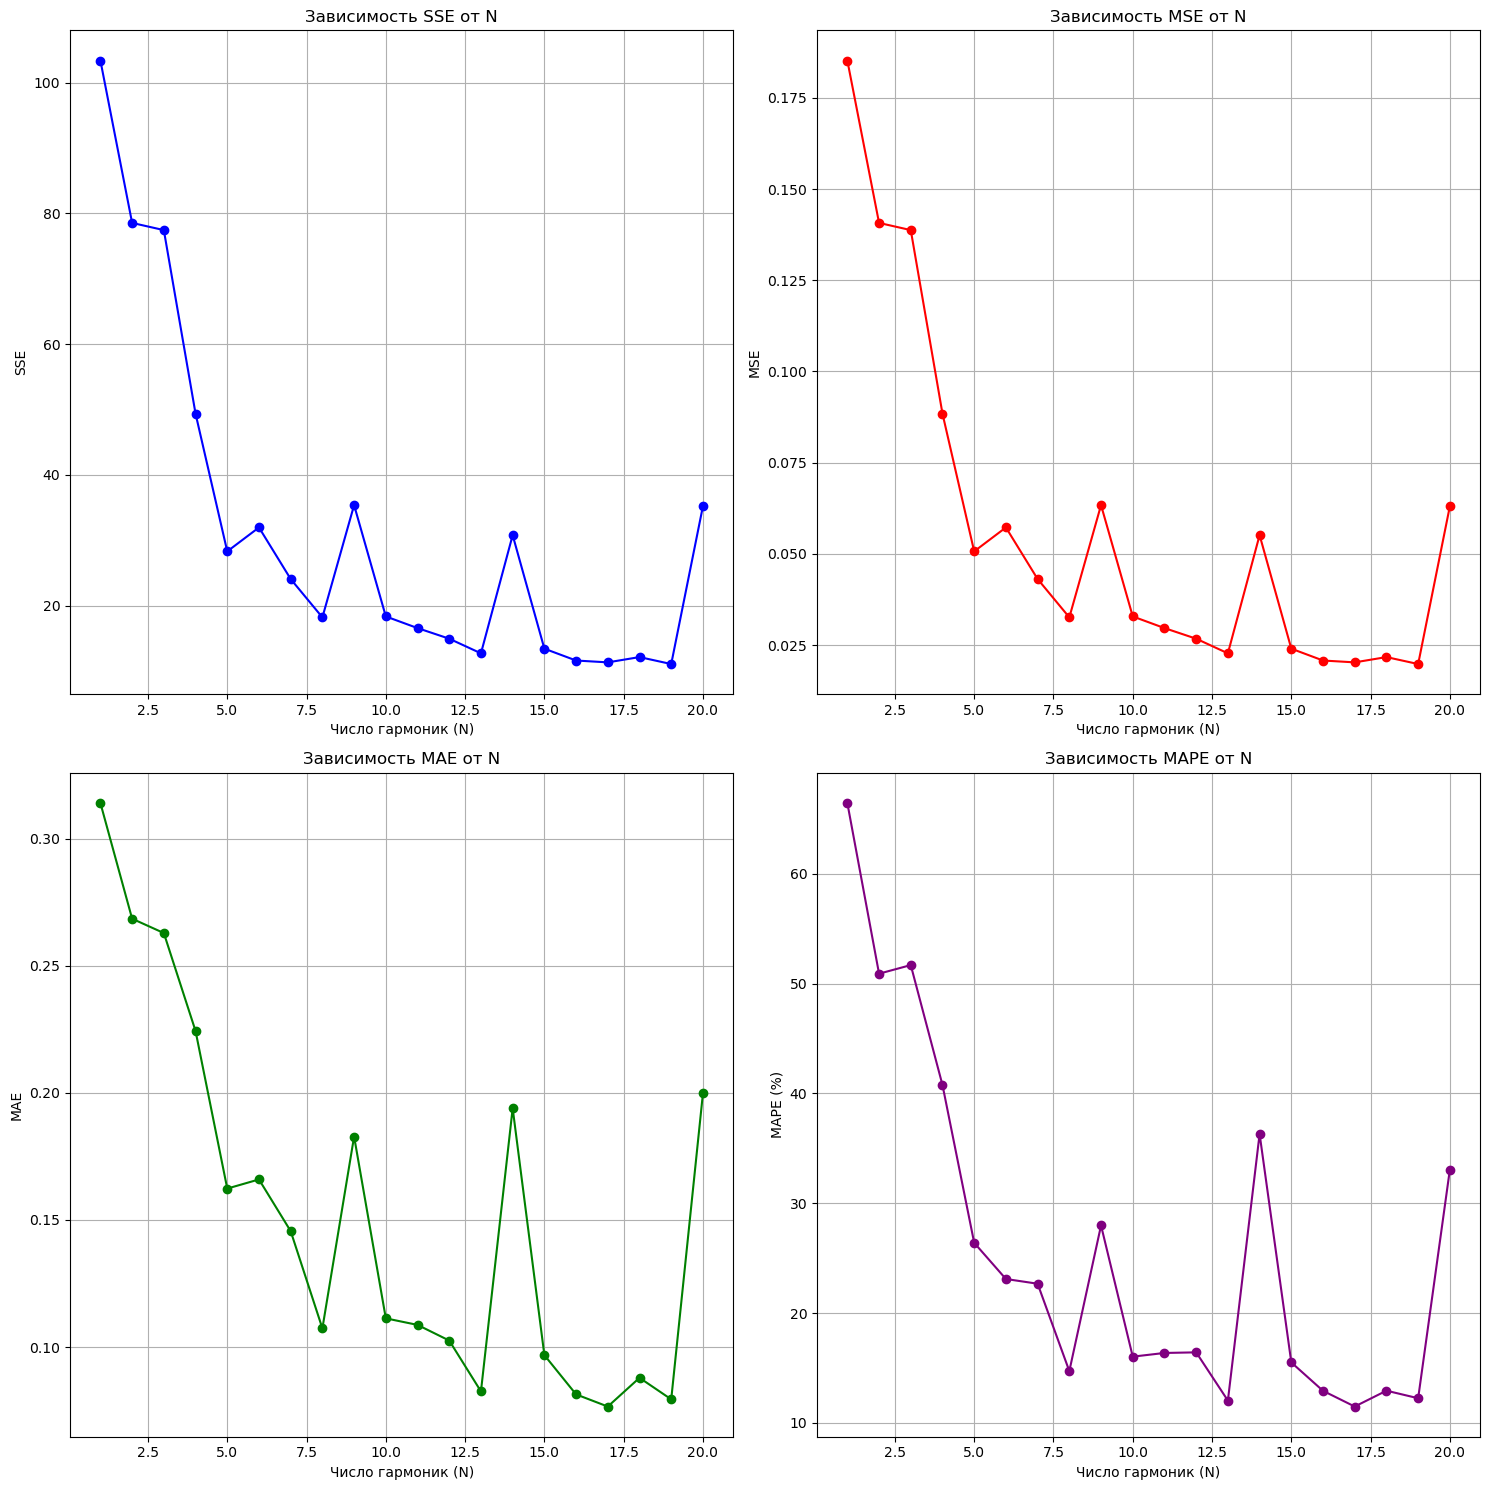

In [10]:
from scipy.signal import savgol_filter

np.random.seed(42)  


N_values = range(1, 21)

errors_sse = []
errors_mse = []
errors_mae = []
errors_mape = []

for N in N_values:

    A, phi = fit_fourier_adam(t, y, N, T)
    y_pred = fourier_series(t, N, A, phi, T)
    errors_sse.append(sse(y, y_pred)) 
    errors_mse.append(mse(y, y_pred)) 
    errors_mae.append(mae(y, y_pred))
    errors_mape.append(mape(y, y_pred))

# Создаем фигуру с 4 подграфиками (2x2)
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# График SSE

axes[0,0].plot(N_values, errors_sse, marker='o', color='blue')
axes[0,0].set_xlabel('Число гармоник (N)')
axes[0,0].set_ylabel('SSE')
axes[0,0].set_title('Зависимость SSE от N')
axes[0,0].grid(True)

# График MSE
axes[0,1].plot(N_values, errors_mse, marker='o', color='red')
axes[0,1].set_xlabel('Число гармоник (N)')
axes[0,1].set_ylabel('MSE')
axes[0,1].set_title('Зависимость MSE от N')
axes[0,1].grid(True)

# таким образом можно добавить сглаживание кривой, но особых результатов оно не дает
#mae_smooth = savgol_filter(errors_mae, window_length=5, polyorder=2)

# График MAE
axes[1,0].plot(N_values, errors_mae, marker='o', color='green')
axes[1,0].set_xlabel('Число гармоник (N)')
axes[1,0].set_ylabel('MAE') 
axes[1,0].set_title('Зависимость MAE от N')
axes[1,0].grid(True)

# График MAPE
axes[1,1].plot(N_values, errors_mape, marker='o', color='purple') 
axes[1,1].set_xlabel('Число гармоник (N)')
axes[1,1].set_ylabel('MAPE (%)')
axes[1,1].set_title('Зависимость MAPE от N')
axes[1,1].grid(True)

plt.tight_layout()
plt.show()

#### Анализ графика метода локтя для рядов Фурье

**Интерпретация результатов:**

1. **Общий тренд** показывает монотонное убывание ошибки, что подтверждает корректность метода
2. **Локальные выбросы** (например, при N = 9, 14, 20) вызваны:
   - Взаимодействием гармоник между собой
   - Попаданием отдельных гармоник на шум в данных

**Ввыбор оптимального N:**
- Для интерпретируемости: 
    N = 5
    (Подходит, если важно объяснить вклад каждой гармоники).

- Для точности без переобучения: 
    N = 13
    (Если хотим минимизировать ошибку).

- Для баланса: 
    N = 8
    (Хорошее снижение ошибки без излишней сложности).


## Визуализация результатов

In [17]:
N = 8
A, phi = fit_fourier_gd(t, y, N, T)
y_approx = fourier_series(t, N, A, phi, T)

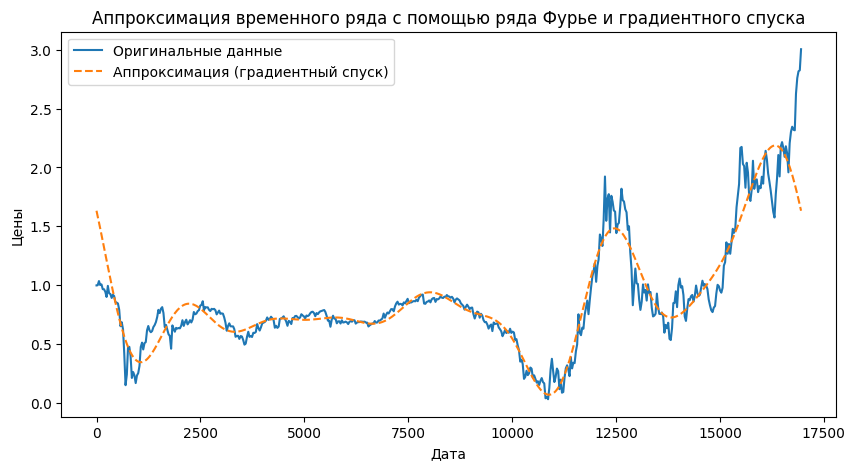

In [18]:
# Визуализация результатов
plt.figure(figsize=(10, 5))
plt.plot(t, y, label='Оригинальные данные')
plt.plot(t, y_approx, label='Аппроксимация (градиентный спуск)', linestyle='--')
plt.xlabel('Дата')
plt.ylabel('Цены')
plt.title('Аппроксимация временного ряда с помощью ряда Фурье и градиентного спуска')
plt.legend()
plt.show()

##  Анализ остатков модели

### Визуализация остатков и их распределение

In [19]:
log_ration = np.log(abs(y/y_approx))
residuals = y - y_approx
residuals_norm = (residuals - np.mean(residuals)) / np.std(residuals)

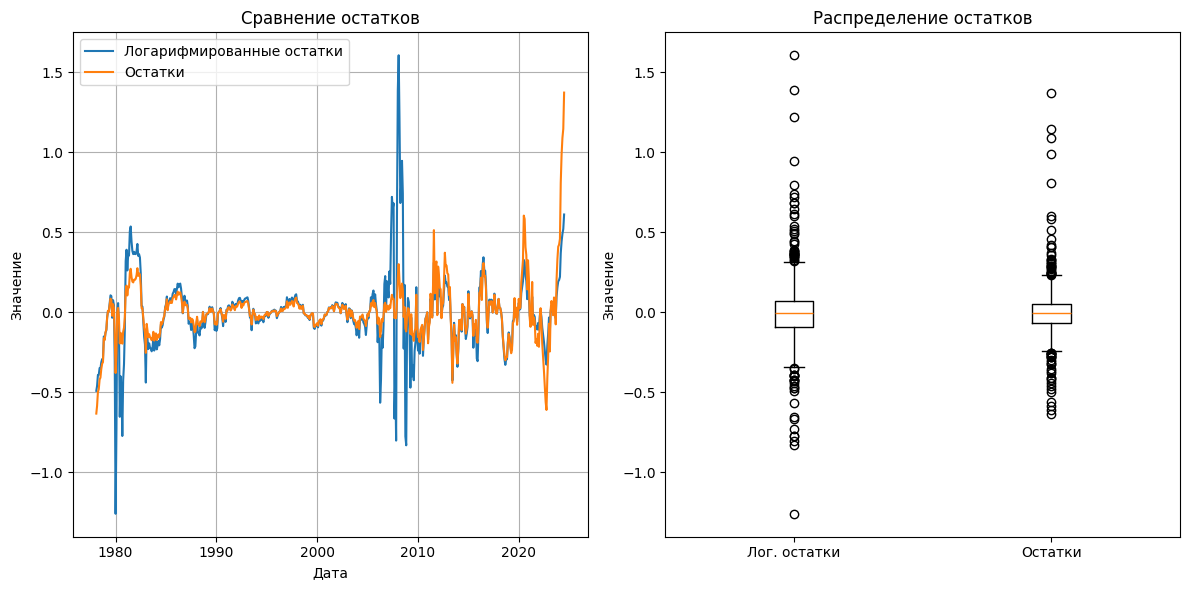

In [20]:
plt.figure(figsize=(12, 6))

t = df['date']
# Левый график - линии остатков
plt.subplot(1, 2, 1)
plt.plot(t, log_ration, label='Логарифмированные остатки')
plt.plot(t, residuals, label='Остатки')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.title('Сравнение остатков')
plt.legend()
plt.grid(True)

# Правый график - boxplot'ы
plt.subplot(1, 2, 2)
plt.boxplot([log_ration, residuals], 
           tick_labels=['Лог. остатки', 'Остатки'])
plt.title('Распределение остатков')
plt.ylabel('Значение')

plt.tight_layout()
plt.show()

Базовая статистика остатков:
Медиана: -0.0044
• Среднее: -0.0000
• STD: 0.1791
• Минимум: -0.6343
• Максимум: 1.3719
• Выбросы (>3σ): 11


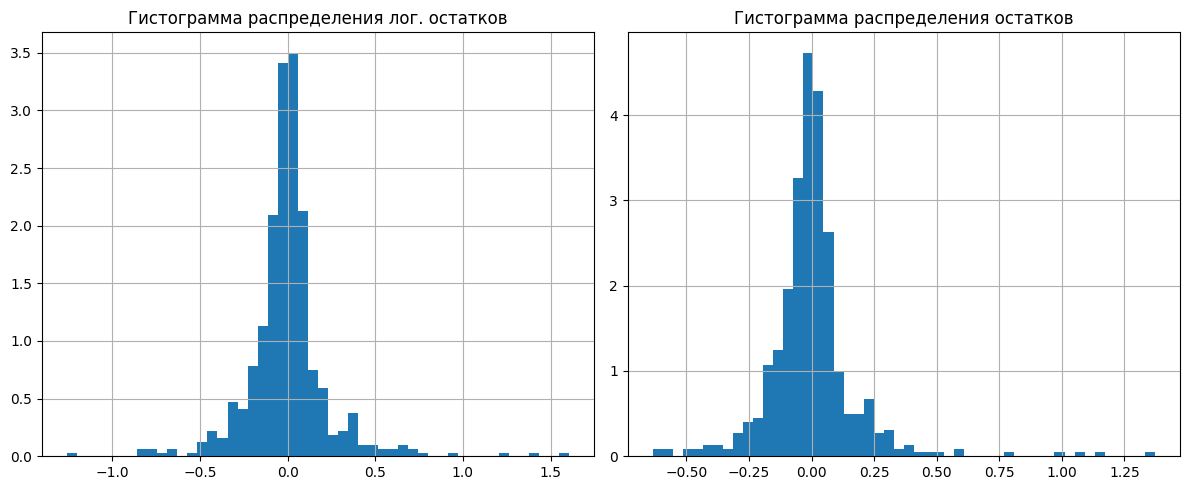

In [21]:
print("Базовая статистика остатков:")
print(f"Медиана: {np.median(residuals):.4f}")
print(f"• Среднее: {np.mean(residuals):.4f}")
print(f"• STD: {np.std(residuals):.4f}")
print(f"• Минимум: {np.min(residuals):.4f}")
print(f"• Максимум: {np.max(residuals):.4f}")
print(f"• Выбросы (>3σ): {np.sum(np.abs(residuals) > 3*np.std(residuals))}")

# Визуализация распределения
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(log_ration, bins=50, density=True)
plt.title('Гистограмма распределения лог. остатков')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=50, density=True)
plt.title('Гистограмма распределения остатков')
plt.grid(True)

plt.tight_layout()
plt.show()

### Методы борьбы с выбросами

Рассмотрим два основных в нашей работе метода борьбы с выбросами, применяя их к логарифмированным остатком, так как они наиболее удобны для рассмотрения из-за наглядности выбросов
 - Winzorizing
 - Медианная замена

In [22]:
#winzorizing
from scipy.stats.mstats import winsorize
winzoring_res = winsorize(log_ration, limits=[0.10, 0.10])

#медианная замена
lower_bound = np.percentile(log_ration, 15)
upper_bound = np.percentile(log_ration, 85)

# Вычисляем медиану для замены выбросов
median = np.median(log_ration)

# Замена значений, выходящих за границы, на медиану
median_res = [median if (x < lower_bound or x > upper_bound) else x for x in log_ration]

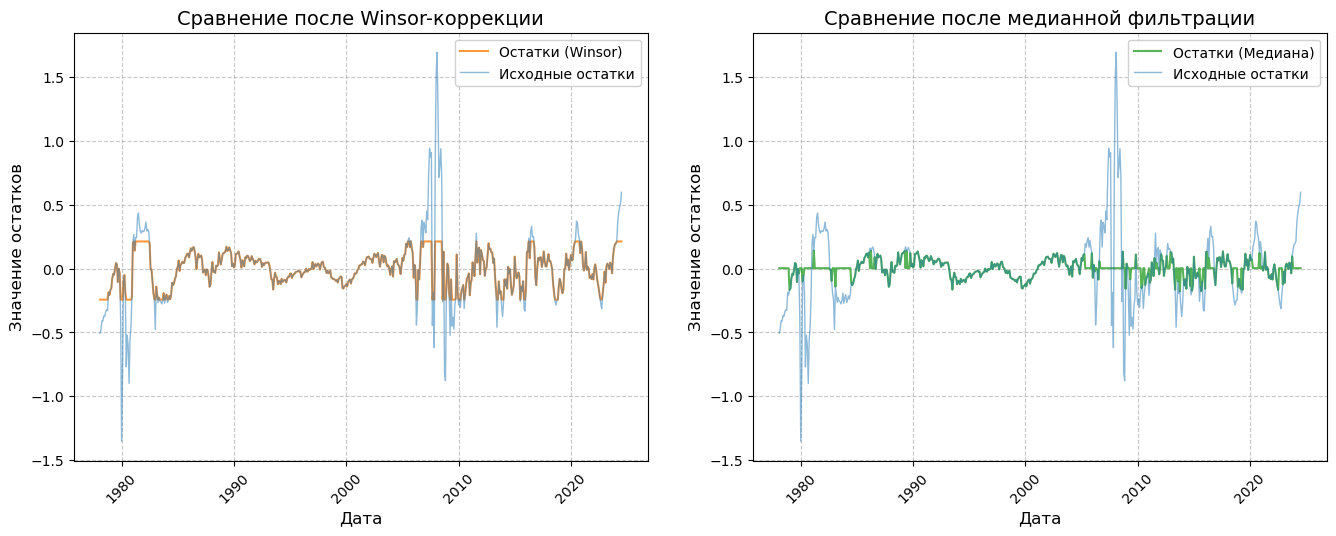

In [17]:
plt.figure(figsize=(14, 6))

# Левый график - Winzorized vs Original
plt.subplot(1, 2, 1)
plt.plot(t, winzoring_res, label='Остатки (Winsor)', linewidth=1.5, alpha=0.8, color='tab:orange')
plt.plot(t, log_ration, label='Исходные остатки', linewidth=1, alpha=0.5, color='tab:blue')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Значение остатков', fontsize=12)
plt.title('Сравнение после Winsor-коррекции', fontsize=14)
plt.legend(fontsize=10, framealpha=0.9, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Правый график - Median vs Original
plt.subplot(1, 2, 2)
plt.plot(t, median_res, label='Остатки (Медиана)', linewidth=1.5, alpha=0.8, color='tab:green')
plt.plot(t, log_ration, label='Исходные остатки', linewidth=1, alpha=0.5, color='tab:blue')
plt.xlabel('Дата', fontsize=12)
plt.ylabel('Значение остатков', fontsize=12)
plt.title('Сравнение после медианной фильтрации', fontsize=14)
plt.legend(fontsize=10, framealpha=0.9, loc='upper right')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.tight_layout(pad=3.0)
plt.show()

### Cтатистические тесты 


Для проверки качества нашей модели аппроксимации проверим наши отфильтрованные остатки различными статистическими тестами, в идеале - остатки должны являться "белым шумом"

Вычислим показатель Херста для остатков модели (https://ru.wikipedia.org/wiki/Показатель_Хёрста)

In [25]:
import nolds

H = nolds.hurst_rs(residuals)
H_log = nolds.hurst_rs(log_ration)
H_norm = nolds.hurst_rs(residuals_norm)
H_win = nolds.hurst_rs(winzoring_res)
H_med = nolds.hurst_rs(median_res)

print('Показатель Херста:')
print(f"Для обычных остатков: {H:.3f}")
print(f"Для лог. остатков: {H_log:.3f}")
print(f"Для нормированных остатков: {H_norm:.3f}")
print(f"Для остатков после Winzorizing: {H_win:.3f}")
print(f"Для остатков после медианной замены: {H_med:.3f}")

Показатель Херста:
Для обычных остатков: 0.937
Для лог. остатков: 0.909
Для нормированных остатков: 0.937
Для остатков после Winzorizing: 0.920
Для остатков после медианной замены: 0.824


Вычислим коэфиент детерминации R^2


In [26]:
from sklearn.metrics import r2_score

r2 = r2_score(y, y_approx)
print(f"R² = {r2:.3f}")
# коэфицент детерминации (хорошее знач - 0.8 - 0.9)


R² = 0.861


Проверим наши остатки на нормальность с помощью двух тестов:
 - Шапиро-Уилка
 - Колмогорова-Смирнова

In [28]:
import scipy.stats as stats

def make_stat_test(data):
  shapiro_test = stats.shapiro(data)
  print("1 :", shapiro_test.pvalue)

  ks_test = stats.kstest(data, 'norm', args=(np.mean(data), np.std(data, ddof=1)))
  print("2 :", ks_test.pvalue)

print('Значения p_value (1 - Шапиро-Уилк   2 - Комлогоров-Смирнов)')
print(f"Для обычных остатков:")
make_stat_test(residuals)

print(f"\nДля лог. остатков: ")
make_stat_test(log_ration)

print(f"\nДля нормированных остатков")
make_stat_test(residuals_norm)

print(f"\nДля остатков после Winzorizing:")
make_stat_test(winzoring_res)

print(f"\nДля остатков после медианной замены:")
make_stat_test(median_res)


Значения p_value (1 - Шапиро-Уилк   2 - Комлогоров-Смирнов)
Для обычных остатков:
1 : 8.53010871312151e-25
2 : 5.948527480117492e-14

Для лог. остатков: 
1 : 9.199907850519694e-23
2 : 5.586306491015849e-12

Для нормированных остатков
1 : 8.530108713121022e-25
2 : 5.948527480117492e-14

Для остатков после Winzorizing:
1 : 2.4318096326004446e-12
2 : 0.01915292712940191

Для остатков после медианной замены:
1 : 8.320556963613957e-13
2 : 4.140657079933131e-15
